## Detailed pipeline overview — what happens and why

This notebook follows a **full ML pipeline** for CHD risk prediction. Here is the big picture:

1. **Load & inspect the data**  
   - We read `framingham.csv` into a DataFrame and print its shape and first rows.  
   - **Why:** sanity‑check that the file is correct and see what features we have (age, blood pressure, cholesterol, etc.).

2. **Basic preprocessing**  
   - Drop completely empty rows/columns.  
   - Convert object‑type columns to numeric where possible.  
   - Handle missing values (median imputation for numeric columns; finally drop any rows that are still problematic).  
   - **Why:** most ML models require clean numeric matrices with no NaNs. This step ensures the dataset is usable and stable for all later steps.

3. **Feature engineering**  
   - Create clinically meaningful features like **pulse pressure** (sysBP − diaBP), **mean arterial pressure (MAP)**, and an interaction **age × systolic BP**.  
   - Define `X` (all predictor columns) and `y` (the 10‑year CHD outcome).  
   - **Why:** engineered features can capture relationships (e.g., vascular stiffness) that raw columns alone do not express cleanly, improving model power.

4. **mRMR feature selection (supervised)**  
   - Use **mutual information** with the target to measure how informative each feature is.  
   - Penalize picking features that are highly correlated with already‑selected ones (to reduce redundancy).  
   - Greedily select ~10 features that are **highly relevant but not redundant**.  
   - **Why:** a small, well‑chosen subset can improve generalization, reduce noise, and make the model easier to interpret.

5. **PCA feature set (unsupervised dimensionality reduction)**  
   - Standardize features, then apply **PCA** to get 12 principal components.  
   - These components are linear combinations of original features and are mutually uncorrelated.  
   - **Why:** PCA compresses information into a lower‑dimensional space and removes multicollinearity, which can help some models and make optimization easier.

6. **Class balancing via manual oversampling**  
   - The outcome is imbalanced (few CHD=1 vs. many CHD=0).  
   - We oversample the minority class by duplicating its rows until both classes have equal counts.  
   - **Why:** this helps the model pay attention to the rare positive class rather than "cheating" by always predicting the majority class.

7. **Train & compare multiple model configurations on each feature set**  
   - Use 10‑fold **StratifiedKFold** cross‑validation to keep class ratios similar in each fold.  
   - Evaluate multiple models with different complexity levels: ExtraTrees, RandomForest, GradientBoosting, DecisionTree, LogisticRegression, SVC, MLP, and optionally XGBoost.
   - Each model is tested in **simple, medium, and complex** configurations to explore the bias-variance tradeoff.
   - Compute metrics: accuracy, precision, recall, F1, ROC‑AUC, plus model size, training time, and prediction latency.  
   - **Why:** instead of assuming one model/feature set is best, we **empirically compare** them and see which combination works best for both performance and deployment constraints.

8. **Hyperparameter tuning for ExtraTrees on PCA features**  
   - Once we identify a strong combination (ExtraTrees + PCA), we tune its hyperparameters using **RandomizedSearchCV** with ROC‑AUC scoring.  
   - **Why:** tuning lets the model find a better bias–variance trade‑off and typically improves performance beyond default settings.

9. **Final evaluation on a held‑out test split**  
   - Split the (balanced PCA) data into train and test once.  
   - Train on the train set, evaluate only on the test set, and report all metrics.  
   - **Why:** this is our **honest, final estimate** of performance on unseen patients.

10. **Explainability: SHAP (global+local) and LIME (local)**  
   - **SHAP**: uses Shapley values to measure each feature's contribution to predictions across the dataset (global) and for specific individuals (local).  
   - **LIME**: approximates the model locally around a single point with a simple surrogate to explain one prediction.  
   - **Why:** in healthcare, we must understand *why* the model flags a patient as high‑risk. XAI methods provide transparency and help detect spurious behavior.

11. **Save the final model**  
   - Store the tuned ExtraTrees model with joblib.  
   - **Why:** so you can reuse it later (in another notebook, an API, or a simple app) without retraining every time.

In [2]:
# Install required libraries (Google Colab friendly)
# Run this once at the start of your Colab session.
!pip install -q numpy pandas scikit-learn matplotlib seaborn xgboost catboost shap lime



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Framingham Heart Disease Risk Pipeline

This notebook builds and explains a **10‑year coronary heart disease (CHD) risk classifier** using the Framingham Heart Study dataset.  
It run smoothly on **Google Colab** and is heavily commented so you can understand *what* happens at each step and *why* it is done that way.

### How to use this notebook in Colab

1. **Run the install cell** right below this (it uses `!pip` to install all needed libraries).
2. **Run the data loading cell**:  
   - If `framingham.csv` is already in the working directory, it will be loaded directly.  
   - If not, Colab will ask you to **upload** the CSV file manually.
3. Then run the remaining cells **in order**:
   - Data cleaning & feature engineering  
   - Feature selection with **mRMR** and dimensionality reduction with **PCA**  
   - Class balancing (oversampling)  
   - Training and comparing several models  
   - Hyperparameter tuning for the best model  
   - **Explainable AI (XAI)** with SHAP (global & local) and LIME (local)  
   - Saving the final trained model for reuse.


In [3]:
import importlib
import subprocess
import sys

def ensure_package(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
        print(f"{pkg} already installed.")
    except ImportError:
        print(f"Installing {pkg}...")
        # Do not fail the notebook if installation fails (e.g. offline environment)
        subprocess.run([sys.executable, "-m", "pip", "install", pkg], check=False)

packages = [
    ("numpy", "numpy"),
    ("pandas", "pandas"),
    ("scikit-learn", "sklearn"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("xgboost", "xgboost"),
    ("catboost", "catboost"),
    ("shap", "shap"),
    ("lime", "lime"),
]

for pkg, import_name in packages:
    ensure_package(pkg, import_name)


numpy already installed.
pandas already installed.
scikit-learn already installed.
matplotlib already installed.
seaborn already installed.
xgboost already installed.
catboost already installed.
shap already installed.
lime already installed.


c:\Users\hadi\Desktop\49000\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 Dataset path (kaggle): https://www.kaggle.com/datasets/aasheesh200/framingham-heart-study-dataset?select=framingham.csv

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

# Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and models

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
)


# Models

In [7]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Try to import xgboost and catboost if available
from xgboost import XGBClassifier

from catboost import CatBoostClassifier


# XAI

In [8]:
import shap

from lime.lime_tabular import LimeTabularExplainer



# 1. Load dataset


In [9]:
import kagglehub
import shutil
from pathlib import Path

# Download dataset from Kaggle
downloaded_path = kagglehub.dataset_download("aasheesh200/framingham-heart-study-dataset")
print(f"Dataset downloaded to: {downloaded_path}")

# Define the target directory (current working directory)
target_dir = Path.cwd()
target_csv = target_dir / "framingham.csv"

# Find the CSV in the downloaded path
source_csv = Path(downloaded_path) / "framingham.csv"

# Copy to current directory if not already there
if source_csv.exists() and not target_csv.exists():
    shutil.copy2(source_csv, target_csv)
    print(f"Copied framingham.csv to: {target_csv}")
elif target_csv.exists():
    print(f"framingham.csv already exists in: {target_csv}")
else:
    print(f"Warning: Could not find framingham.csv in {downloaded_path}")
    
data_path = target_csv

Dataset downloaded to: C:\Users\hadi\.cache\kagglehub\datasets\aasheesh200\framingham-heart-study-dataset\versions\1
framingham.csv already exists in: c:\Users\hadi\Desktop\49000\framingham.csv


In [10]:
# Verify the path
print(f"Data path: {data_path}")
print(f"File exists: {data_path.exists()}")

Data path: c:\Users\hadi\Desktop\49000\framingham.csv
File exists: True


In [11]:
# Load the dataset
print(f"Using data file: {data_path}")
df = pd.read_csv(data_path)
print("Loaded:", df.shape)
display(df.head())

Using data file: c:\Users\hadi\Desktop\49000\framingham.csv
Loaded: (4238, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0



# 2. Basic preprocessing

Drops columns and rows that are completely empty.



Prints how many missing values each column has.


In [12]:
print("Initial shape:", df.shape)
print("\nInitial dtypes:\n", df.dtypes)
print("\nInitial missing values per column:\n", df.isna().sum())

# Drop columns where every value is NaN
df = df.dropna(axis=1, how='all')

# Drop rows where every value is NaN
df = df.dropna(axis=0, how='all')

print("\nAfter dropping completely empty rows/cols, shape:", df.shape)



Initial shape: (4238, 16)

Initial dtypes:
 male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

Initial missing values per column:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

After dropping completely empty rows/cols, shape: (4238, 16)


In [13]:
fake_missing_values = ["NA", "N/A", "?", " ", ""]
df = df.replace(fake_missing_values, np.nan)

print("\nMissing values per column after normalizing fake NAs:\n", df.isna().sum())

# ------------------------------------------------------------------
# Robust numeric preprocessing:
# - Drop rows with missing target
# - Drop very high-missing numeric columns (>40% missing)
# - Median-impute remaining numeric features
# - Light outlier clipping (1st–99th percentile) on features
# ------------------------------------------------------------------
TARGET_COL = "TenYearCHD"

# 1) Drop rows where the target is missing (cannot be used for supervised learning)
if TARGET_COL in df.columns:
    before_rows = df.shape[0]
    df = df[~df[TARGET_COL].isna()].copy()
    dropped_target = before_rows - df.shape[0]
    print(f"Dropped {dropped_target} rows with missing {TARGET_COL}.")

# 2) Work only with numeric columns for imputation
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns detected (for imputation/outlier handling):\n", num_cols)

if num_cols:
    # Fraction of missing in each numeric column
    missing_frac = df[num_cols].isna().mean().sort_values(ascending=False)
    print("\nNumeric missing fraction (pre‑imputation):\n", missing_frac)

    # 3) Drop numeric columns with very high missingness
    high_missing = missing_frac[missing_frac > 0.40].index.tolist()
    if high_missing:
        print("\nDropping high‑missing numeric columns (>40% missing):", high_missing)
        df = df.drop(columns=high_missing)
        num_cols = [c for c in num_cols if c not in high_missing]

    # 4) Median imputation for remaining numeric columns
    if num_cols:
        imputer = SimpleImputer(strategy="median")
        df[num_cols] = imputer.fit_transform(df[num_cols])
        print("\nImputed numeric columns with median.")

        # 5) Light outlier clipping on feature columns (not on the target)
        clip_cols = [c for c in num_cols if c != TARGET_COL]
        for col in clip_cols:
            lower = df[col].quantile(0.01)
            upper = df[col].quantile(0.99)
            df[col] = df[col].clip(lower, upper)
        print("Applied 1st–99th percentile clipping on numeric feature columns.")

# 6) Final sanity check: drop any remaining rows with NaNs anywhere
before_rows = df.shape[0]
df = df.dropna(axis=0, how="any")
after_rows = df.shape[0]
print(f"\nDropped {before_rows - after_rows} rows with residual NaNs after imputation.")
print("\nFinal missing values per column:\n", df.isna().sum())



Missing values per column after normalizing fake NAs:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64
Dropped 0 rows with missing TenYearCHD.

Numeric columns detected (for imputation/outlier handling):
 ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']

Numeric missing fraction (pre‑imputation):
 glucose            0.091553
education          0.024776
BPMeds             0.012506
totChol            0.011798
cigsPerDay         0.006843
BMI                0.004483
heartRate          0.000236
male               0.000000
p


# 3. Feature engineering (pulse pressure, MAP, interactions)
 As described in paper (pulse pressure, mean arterial pressure, Age*SystolicBP)
 The framingham dataset columns: check names


In [14]:
print("Columns:", df.columns.tolist())

# Typical columns in this dataset include:
# 'male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
# 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
# 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'

# Create features if exist
if 'sysBP' in df.columns and 'diaBP' in df.columns:
    df['pulse_pressure'] = df['sysBP'] - df['diaBP']
    df['MAP'] = (2 * df['diaBP'] + df['sysBP']) / 3

if 'age' in df.columns and 'sysBP' in df.columns:
    df['age_x_sysBP'] = df['age'] * df['sysBP']

# Drop any redundant columns if needed (none for now)
print("After FE shape:", df.shape)

# Separate features and target
TARGET = 'TenYearCHD'
if TARGET not in df.columns:
    raise ValueError("Target TenYearCHD not found in dataset")

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

Columns: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']
After FE shape: (4238, 19)


# 4. mRMR implementation (simple greedy using mutual information)
Paper used mRMR producing 10 features; we'll implement greedy mRMR


### what is mRMR and what are we using from it?

**mRMR (Minimum Redundancy, Maximum Relevance)** is a supervised feature selection strategy:

- **Maximum relevance:** pick features that individually have high mutual information with the target (`TenYearCHD`).  
  - Mutual information measures how much knowing a feature reduces uncertainty about the label.
- **Minimum redundancy:** avoid selecting features that are highly correlated with each other.  
  - If two features say almost the same thing, keeping both adds complexity but little new information.

In this notebook, `mrmr_select`:

1. Computes mutual information between each feature and `y`.  
2. Starts with the single most relevant feature.  
3. Iteratively adds features that maximize:  
   

   `score(feature) = relevance_to_target − average_redundancy_to_already_selected`

4. Stops after selecting `k = 10` features.

We then build **`X_mrmr`** by taking only these selected columns:

```python
X_mrmr = X[mrmr_features].copy()
```

This gives us a **compact, human‑understandable set of important predictors** which we can compare against:

- `X_orig` — all engineered features  
- `X_pca_df` — 12 PCA components (dense, decorrelated representation)


In [15]:
from sklearn.feature_selection import mutual_info_classif

def mrmr_select(X_df, y_series, k):
    X_np = X_df.copy()
    features = list(X_np.columns)
    mi = mutual_info_classif(X_np, y_series, discrete_features='auto', random_state=42)
    mi_dict = dict(zip(features, mi))
    selected = []
    # 1) pick feature with highest MI
    first = max(mi_dict, key=mi_dict.get)
    selected.append(first)
    while len(selected) < k:
        candidates = [f for f in features if f not in selected]
        best_score = -np.inf
        best_feat = None
        for f in candidates:
            relevance = mi_dict[f]
            redundancy = 0.0
            if len(selected) > 0:
                # compute avg pairwise MI between f and selected features
                redundances = []
                for s in selected:
                    redundances.append(mutual_info_classif(X_np[[f, s]], y_series, discrete_features='auto', random_state=0)[0] if False else mutual_info_classif(X_np[[f]], X_np[s])[0] if False else 0.0)
                # computing redundancy via absolute correlation as proxy (faster)
                redundances = [abs(np.corrcoef(X_np[f], X_np[s])[0,1]) for s in selected]
                redundancy = np.mean(redundances)
            # score = relevance - redundancy (mRMR idea)
            score = relevance - redundancy
            if score > best_score:
                best_score = score
                best_feat = f
        if best_feat is None:
            break
        selected.append(best_feat)
    return selected

# We'll attempt to pick 10 features via mRMR as in paper
mrmr_k = 10
mrmr_features = mrmr_select(X, y, mrmr_k)
print("mRMR selected features:", mrmr_features)


mRMR selected features: ['age_x_sysBP', 'male', 'diabetes', 'education', 'heartRate', 'BPMeds', 'currentSmoker', 'totChol', 'glucose', 'BMI']


# 5. PCA: scale then PCA to 12 components

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=12, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_.sum()
print(f"PCA 12 components explained variance: {explained:.4f}")

# We'll build three feature sets per paper: Original (all), mRMR (selected), PCA (12 comps)
X_orig = X.copy()
X_mrmr = X[mrmr_features].copy()
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])


PCA 12 components explained variance: 0.9626


# 6. Balancing: manual oversampling minority to match majority 


In [17]:
def manual_oversample(Xf, yf):
    counts = yf.value_counts()
    if counts.min() < 10:
        print("Minority class < 10, skipping oversampling.")
        return Xf, yf
    if counts.nunique() == 1:
        print("Only one class present, skipping oversampling.")
        return Xf, yf
    maj = counts.idxmax()
    max_count = counts.max()
    X_res = Xf.copy()
    y_res = yf.copy()
    for cls, cnt in counts.items():
        if cnt < max_count:
            need = max_count - cnt
            idx = np.where(yf == cls)[0]
            # sample with replacement
            choice = np.random.choice(idx, size=need, replace=True)
            X_res = pd.concat([X_res, Xf.iloc[choice]], axis=0, ignore_index=True)
            y_res = pd.concat([y_res, yf.iloc[choice]], axis=0, ignore_index=True)
    return X_res, y_res

# Example: apply balancing for PCA-set (convert to df)
X_pca_df_reset = pd.DataFrame(X_pca_df).reset_index(drop=True)
y_reset = y.reset_index(drop=True)
X_pca_bal, y_pca_bal = manual_oversample(X_pca_df_reset, y_reset)
print("After balancing PCA set:", X_pca_bal.shape, y_pca_bal.value_counts())

# For original and mRMR sets:
X_orig_reset = X_orig.reset_index(drop=True)
X_mrmr_reset = X_mrmr.reset_index(drop=True)
X_orig_bal, y_orig_bal = manual_oversample(X_orig_reset, y_reset)
X_mrmr_bal, y_mrmr_bal = manual_oversample(X_mrmr_reset, y_reset)

After balancing PCA set: (7188, 12) TenYearCHD
0    3594
1    3594
Name: count, dtype: int64


# 7. Train/test split (70/30) — per paper they later use 10-fold CV; we'll do both:
  First compute 10-fold stratified CV metrics for each model and each feature set


### Where and why we try different models

The function `evaluate_models` is our **comprehensive model comparison engine** with multiple configuration levels:

- It creates a 10‑fold `StratifiedKFold` object so that each fold has a similar class balance.  
- It defines **multiple configurations for each model type** (simple → medium → complex):
  - **ExtraTreesClassifier**: 3 configurations (50/100/150 estimators with varying complexity)
  - **RandomForestClassifier**: 3 configurations (different n_estimators, min_samples settings, class weighting)
  - **GradientBoostingClassifier**: 3 configurations (varying learning rates, depths, and subsampling)
  - **DecisionTreeClassifier**: 3 configurations (max_depth from 3 to None)
  - **LogisticRegression**: 3 configurations (varying C parameter and class weighting)
  - **SVC (RBF kernel)**: 3 configurations (different C values and class weighting)
  - **MLPClassifier**: 3 configurations (1-layer, 2-layer, 3-layer networks with different sizes)
  - **XGBClassifier** (if installed): 3 configurations (different learning rates and depths)

For every model configuration, it runs `cross_validate` with metrics:

- accuracy  
- precision  
- recall  
- f1  
- roc_auc  

and also measures:

- **Model size** (memory footprint in MB via pickle serialization)
- **Training time** (seconds to fit on full dataset)
- **Cross-validation time** (total time for 10-fold CV)
- **Prediction latency** (milliseconds per sample, averaged over 100 predictions)

Then we call:

```python
res_orig = evaluate_models(X_orig_bal, y_orig_bal, desc="Original (balanced)")
res_mrmr = evaluate_models(X_mrmr_bal, y_mrmr_bal, desc="mRMR (balanced)")
res_pca  = evaluate_models(X_pca_bal, y_pca_bal,   desc="PCA (balanced)")
```

So we are explicitly comparing:

1. **Different feature sets**: original vs. mRMR vs. PCA.  
2. **Different model families**: tree ensembles, boosting, linear models, SVMs, neural networks, etc.
3. **Different complexity levels**: simple (fast, less prone to overfitting) to complex (more capacity, may need more data).
4. **Performance vs. deployment tradeoffs**: accuracy vs. model size vs. prediction speed.

This lets us **see empirically** which combination (model + configuration + feature representation) gives the best balance of metrics before we commit to tuning one model further. The results are sorted by accuracy in the summary table for easy comparison.

### Model Comparison: Multiple Configurations for Each Model Type

Below are the models we'll evaluate, with **simple, medium, and complex** configurations for each to explore the bias-variance tradeoff:

#### 1. **ExtraTreesClassifier** (Extremely Randomized Trees)
- **Simple**: `n_estimators=50`, `max_features='sqrt'` — Fast, baseline configuration
- **Medium**: `n_estimators=100`, `min_samples_split=4` — More trees, slight regularization
- **Complex**: `n_estimators=150`, `max_features=None` — Maximum capacity, uses all features
- **How it works**: Like Random Forest, but makes splits completely at random (doesn't search for best threshold)
- **Pros**: Very fast training, less prone to overfitting, good for high-dimensional data
- **Cons**: May need more trees than Random Forest for same accuracy

#### 2. **RandomForestClassifier**
- **Simple**: `n_estimators=50` — Baseline ensemble
- **Medium**: `n_estimators=100`, `min_samples_split=4`, `min_samples_leaf=2` — More regularization
- **Complex**: `n_estimators=150`, `class_weight='balanced'` — Handles class imbalance explicitly
- **How it works**: Ensemble of decision trees, each trained on bootstrap sample with random feature subsets
- **Pros**: Robust, handles non-linear relationships, built-in feature importance
- **Cons**: Can be slow on large datasets, less interpretable than single tree

#### 3. **GradientBoostingClassifier**
- **Simple**: `n_estimators=50`, `lr=0.1`, `max_depth=3` — Fast boosting baseline
- **Medium**: `n_estimators=100`, `lr=0.05`, `subsample=0.8` — Lower learning rate, stochastic boosting
- **Complex**: `n_estimators=150`, `lr=0.03`, `max_depth=4` — Deeper trees, more iterations
- **How it works**: Builds trees sequentially, each correcting errors of previous ones
- **Pros**: Often best performance, handles feature interactions well
- **Cons**: Slower training, prone to overfitting if not tuned, sensitive to outliers

#### 4. **DecisionTreeClassifier**
- **Simple**: `max_depth=3` — Shallow tree, highly interpretable
- **Medium**: `max_depth=6`, `min_samples_split=4` — Moderate depth with regularization
- **Complex**: `max_depth=None` — Full tree, can overfit
- **How it works**: Single tree that splits data based on feature thresholds to maximize purity
- **Pros**: Highly interpretable, fast prediction, no feature scaling needed
- **Cons**: Very prone to overfitting (especially complex version), unstable

#### 5. **LogisticRegression**
- **Simple**: `C=0.3`, no class weighting — Strong regularization
- **Medium**: `C=1.0`, `class_weight='balanced'` — Moderate regularization, handles imbalance
- **Complex**: `C=3.0`, `class_weight='balanced'` — Less regularization, more model flexibility
- **How it works**: Linear model using logistic (sigmoid) function for binary classification
- **Pros**: Fast, interpretable coefficients, works well with linearly separable data
- **Cons**: Cannot capture complex non-linear patterns without feature engineering

#### 6. **SVC (Support Vector Classifier with RBF kernel)**
- **Simple**: `C=0.8`, `gamma='scale'` — Moderate margin, standard gamma
- **Medium**: `C=2.0`, `class_weight='balanced'` — Tighter margin, handles imbalance
- **Complex**: `C=4.0`, `class_weight='balanced'` — Very tight margin, maximum flexibility
- **How it works**: Finds optimal hyperplane in high-dimensional space via kernel trick
- **Pros**: Effective in high dimensions, memory efficient, versatile via kernels
- **Cons**: Slow on large datasets, sensitive to hyperparameters and scaling

#### 7. **MLPClassifier** (Multi-Layer Perceptron / Neural Network)
- **Simple**: `hidden_layer_sizes=(32,)` — Single hidden layer with 32 neurons
- **Medium**: `hidden_layer_sizes=(64, 32)` — Two layers for deeper representations
- **Complex**: `hidden_layer_sizes=(128, 64, 32)` — Three layers, maximum capacity
- **How it works**: Artificial neural network with backpropagation training
- **Pros**: Can learn complex non-linear patterns, powerful for high-dimensional data
- **Cons**: Needs careful tuning, sensitive to feature scaling, "black box", can overfit

#### 8. **XGBClassifier** (XGBoost - if installed)
- **Simple**: `n_estimators=50`, `lr=0.1`, `max_depth=4` — Fast baseline
- **Medium**: `n_estimators=100`, `lr=0.05`, `max_depth=5` — More iterations, deeper trees
- **Complex**: `n_estimators=150`, `lr=0.03`, `max_depth=6` — Maximum capacity
- **How it works**: Optimized gradient boosting with regularization and parallel processing
- **Pros**: State-of-the-art performance, handles missing values, built-in regularization
- **Cons**: Many hyperparameters to tune, can overfit on small datasets

---

**What we measure for each configuration:**
- **Cross-validation metrics**: accuracy, precision, recall, F1, ROC-AUC (mean ± std across 10 folds)
- **Model size**: memory footprint in MB after serialization (important for deployment)
- **Training time**: how long it takes to train on all data (seconds)
- **CV time**: total cross-validation time (includes all 10 folds)
- **Prediction latency**: average time to predict a single sample in milliseconds (critical for real-time applications)

The results are **sorted by accuracy** in the summary table, making it easy to identify top performers while considering deployment constraints like model size and prediction speed.

In [18]:
import time
import pickle
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Optional libraries
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None


def _nice_time(seconds: float) -> str:
    """Format seconds into a human-readable string."""
    if seconds < 60:
        return f"{seconds:.2f}s"
    m, s = divmod(seconds, 60)
    if m < 60:
        return f"{int(m)}m {s:.1f}s"
    h, m = divmod(m, 60)
    return f"{int(h)}h {int(m)}m"


def evaluate_models(X_df, y_series, desc=""):
    """
    Evaluate multiple ML models with cross-validation and performance metrics.
    Returns detailed comparison including accuracy, size, and latency.
    Now uses multiple configurations per model (simple → medium → complex).
    """
    banner = f"=== Evaluating for {desc} ==="
    print("\n" + "=" * len(banner))
    print(banner)
    print("=" * len(banner) + "\n")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # ------------------------------------------------------------------
    # Model configurations: (name, estimator_instance, config_description)
    # Simple → Medium → Complex for each base model
    # ------------------------------------------------------------------
    model_specs = []

    # ExtraTrees
    model_specs.append((
        "ExtraTrees_simple",
        ExtraTreesClassifier(
            n_estimators=50,
            max_depth=None,
            max_features="sqrt",
            n_jobs=-1,
            random_state=42,
        ),
        "ExtraTrees: n_estimators=50, max_depth=None, max_features='sqrt'"
    ))
    model_specs.append((
        "ExtraTrees_medium",
        ExtraTreesClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_split=4,
            n_jobs=-1,
            random_state=42,
        ),
        "ExtraTrees: n_estimators=100, min_samples_split=4, max_features='sqrt'"
    ))
    model_specs.append((
        "ExtraTrees_complex",
        ExtraTreesClassifier(
            n_estimators=150,
            max_depth=None,
            max_features=None,
            min_samples_split=4,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=42,
        ),
        "ExtraTrees: n_estimators=150, max_features=None, min_samples_split=4"
    ))

    # RandomForest
    model_specs.append((
        "RandomForest_simple",
        RandomForestClassifier(
            n_estimators=50,
            max_depth=None,
            max_features="sqrt",
            n_jobs=-1,
            random_state=42,
        ),
        "RandomForest: n_estimators=50, max_features='sqrt'"
    ))
    model_specs.append((
        "RandomForest_medium",
        RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features="sqrt",
            n_jobs=-1,
            random_state=42,
        ),
        "RandomForest: n_estimators=100, min_samples_split=4, min_samples_leaf=2"
    ))
    model_specs.append((
        "RandomForest_complex",
        RandomForestClassifier(
            n_estimators=150,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt",
            n_jobs=-1,
            class_weight="balanced",
            random_state=42,
        ),
        "RandomForest: n_estimators=150, class_weight='balanced'"
    ))

    # GradientBoosting
    model_specs.append((
        "GB_simple",
        GradientBoostingClassifier(
            n_estimators=50,
            learning_rate=0.1,
            max_depth=3,
            random_state=42,
        ),
        "GradientBoosting: n_estimators=50, lr=0.1, max_depth=3"
    ))
    model_specs.append((
        "GB_medium",
        GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            random_state=42,
        ),
        "GradientBoosting: n_estimators=100, lr=0.05, subsample=0.8"
    ))
    model_specs.append((
        "GB_complex",
        GradientBoostingClassifier(
            n_estimators=150,
            learning_rate=0.03,
            max_depth=4,
            subsample=0.8,
            random_state=42,
        ),
        "GradientBoosting: n_estimators=150, lr=0.03, max_depth=4, subsample=0.8"
    ))

    # DecisionTree
    model_specs.append((
        "DecisionTree_simple",
        DecisionTreeClassifier(
            max_depth=3,
            random_state=42,
        ),
        "DecisionTree: max_depth=3"
    ))
    model_specs.append((
        "DecisionTree_medium",
        DecisionTreeClassifier(
            max_depth=6,
            min_samples_split=4,
            random_state=42,
        ),
        "DecisionTree: max_depth=6, min_samples_split=4"
    ))
    model_specs.append((
        "DecisionTree_complex",
        DecisionTreeClassifier(
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42,
        ),
        "DecisionTree: max_depth=None, min_samples_split=2, min_samples_leaf=1"
    ))

    # LogisticRegression
    model_specs.append((
        "LogReg_simple",
        LogisticRegression(
            penalty="l2",
            C=0.3,
            solver="lbfgs",
            max_iter=1000,
            class_weight=None,
            n_jobs=-1,
            random_state=42,
        ),
        "LogReg: C=0.3, no class_weight, max_iter=1000"
    ))
    model_specs.append((
        "LogReg_medium",
        LogisticRegression(
            penalty="l2",
            C=1.0,
            solver="lbfgs",
            max_iter=1500,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
        ),
        "LogReg: C=1.0, class_weight='balanced', max_iter=1500"
    ))
    model_specs.append((
        "LogReg_complex",
        LogisticRegression(
            penalty="l2",
            C=3.0,
            solver="lbfgs",
            max_iter=2000,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
        ),
        "LogReg: C=3.0, class_weight='balanced', max_iter=2000"
    ))

    # SVC (RBF)
    model_specs.append((
        "SVC_simple",
        SVC(
            kernel="rbf",
            C=0.8,
            gamma="scale",
            probability=True,
            class_weight=None,
            random_state=42,
        ),
        "SVC RBF: C=0.8, gamma='scale', no class_weight"
    ))
    model_specs.append((
        "SVC_medium",
        SVC(
            kernel="rbf",
            C=2.0,
            gamma="scale",
            probability=True,
            class_weight="balanced",
            random_state=42,
        ),
        "SVC RBF: C=2.0, gamma='scale', class_weight='balanced'"
    ))
    model_specs.append((
        "SVC_complex",
        SVC(
            kernel="rbf",
            C=4.0,
            gamma="scale",
            probability=True,
            class_weight="balanced",
            random_state=42,
        ),
        "SVC RBF: C=4.0, gamma='scale', class_weight='balanced'"
    ))

    # MLPs (simple → deep)
    model_specs.append((
        "MLP_simple",
        MLPClassifier(
            hidden_layer_sizes=(32,),
            activation="relu",
            solver="adam",
            alpha=0.001,
            learning_rate="adaptive",
            learning_rate_init=0.001,
            max_iter=400,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=15,
            random_state=42,
        ),
        "MLP: hidden_layer_sizes=(32,), alpha=0.001, max_iter=400"
    ))
    model_specs.append((
        "MLP_medium",
        MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            solver="adam",
            alpha=0.0005,
            learning_rate="adaptive",
            learning_rate_init=0.001,
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20,
            random_state=42,
        ),
        "MLP: hidden_layer_sizes=(64, 32), alpha=0.0005, max_iter=500"
    ))
    model_specs.append((
        "MLP_complex",
        MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation="relu",
            solver="adam",
            alpha=0.001,
            learning_rate="adaptive",
            learning_rate_init=0.001,
            max_iter=600,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=25,
            batch_size=64,
            random_state=42,
        ),
        "MLP: hidden_layer_sizes=(128, 64, 32), alpha=0.001, batch_size=64, max_iter=600"
    ))

    # XGBoost (if available)
    if XGBClassifier is not None:
        model_specs.append((
            "XGB_simple",
            XGBClassifier(
                n_estimators=50,
                learning_rate=0.1,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda=1.0,
                objective="binary:logistic",
                eval_metric="logloss",
                use_label_encoder=False,
                random_state=42,
                verbosity=0,
            ),
            "XGBoost: n_estimators=50, lr=0.1, max_depth=4, subsample=0.8, colsample_bytree=0.8"
        ))
        model_specs.append((
            "XGB_medium",
            XGBClassifier(
                n_estimators=100,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda=1.0,
                objective="binary:logistic",
                eval_metric="logloss",
                use_label_encoder=False,
                random_state=42,
                verbosity=0,
            ),
            "XGBoost: n_estimators=100, lr=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8"
        ))
        model_specs.append((
            "XGB_complex",
            XGBClassifier(
                n_estimators=150,
                learning_rate=0.03,
                max_depth=6,
                subsample=0.85,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                objective="binary:logistic",
                eval_metric="logloss",
                use_label_encoder=False,
                random_state=42,
                verbosity=0,
            ),
            "XGBoost: n_estimators=150, lr=0.03, max_depth=6, subsample=0.85, colsample_bytree=0.9"
        ))

    results = {}
    scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

    # ------------------------------------------------------------------
    # Main evaluation loop
    # ------------------------------------------------------------------
    for name, model, config_desc in model_specs:
        print(f"\n{name}")
        print("-" * len(name))
        print(f"  Configuration: {config_desc}")

        # -----------------------------
        # Cross-validation performance
        # -----------------------------
        cv_start = time.time()
        cv_res = cross_validate(
            model,
            X_df,
            y_series,
            cv=skf,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1,
        )
        cv_time = time.time() - cv_start

        summary = {
            metric: (
                np.mean(cv_res[f"test_{metric}"]),
                np.std(cv_res[f"test_{metric}"]),
            )
            for metric in scoring
        }

        # -----------------------------
        # Train on full dataset
        # -----------------------------
        train_start = time.time()
        model.fit(X_df, y_series)
        train_time = time.time() - train_start

        # Model size
        model_bytes = len(pickle.dumps(model))
        model_size_mb = model_bytes / (1024 * 1024)

        # Prediction latency (single-sample)
        sample = X_df.iloc[:1]
        latencies = []
        for _ in range(100):
            start = time.time()
            _ = model.predict(sample)
            latencies.append((time.time() - start) * 1000.0)  # ms
        avg_latency_ms = np.mean(latencies)

        # Store results (including config description)
        results[name] = {
            "metrics": summary,
            "model_size_mb": model_size_mb,
            "train_time_s": train_time,
            "cv_time_s": cv_time,
            "latency_ms": avg_latency_ms,
            "config": config_desc,
        }

        # -----------------------------
        # Per-model printout
        # -----------------------------
        print("  Cross-Validation Metrics (10-fold):")
        for metric, (m, s) in summary.items():
            print(f"    {metric:12s}: {m:7.4f} ± {s:7.4f}")

        print("\n  Model Characteristics:")
        print(f"    Model Size        : {model_size_mb:7.2f} MB")
        print(f"    Training Time     : {_nice_time(train_time)}")
        print(f"    CV Time (total)   : {_nice_time(cv_time)}")
        print(f"    Prediction Latency: {avg_latency_ms:7.3f} ms/sample")

    # ------------------------------------------------------------------
    # Summary comparison table with ALL metrics, sorted by accuracy
    # ------------------------------------------------------------------
    print("\n" + "=" * 120)
    print("SUMMARY COMPARISON - ALL METRICS")
    print("=" * 120)
    header = (
        f"{'Model':<18}"
        f"{'Accuracy':>10}"
        f"{'Precision':>11}"
        f"{'Recall':>10}"
        f"{'F1':>10}"
        f"{'ROC-AUC':>10}"
        f"{'Size(MB)':>10}"
        f"{'Train(s)':>10}"
        f"{'Latency(ms)':>13}"
    )
    print(header)
    print("-" * 120)

    sorted_items = sorted(
        results.items(),
        key=lambda kv: kv[1]["metrics"]["accuracy"][0],
        reverse=True,
    )

    for name, res in sorted_items:
        acc = res["metrics"]["accuracy"][0]
        prec = res["metrics"]["precision"][0]
        rec = res["metrics"]["recall"][0]
        f1 = res["metrics"]["f1"][0]
        roc = res["metrics"]["roc_auc"][0]
        size = res["model_size_mb"]
        train_t = res["train_time_s"]
        lat = res["latency_ms"]

        print(
            f"{name:<18}"
            f"{acc:10.4f}"
            f"{prec:11.4f}"
            f"{rec:10.4f}"
            f"{f1:10.4f}"
            f"{roc:10.4f}"
            f"{size:10.2f}"
            f"{train_t:10.2f}"
            f"{lat:13.3f}"
        )
        # Also print config on the next line for clarity
        print(f"    Config: {res['config']}")

    print("=" * 120 + "\n")

    return results


# ----------------------------------------------------------------------
# Example usage with your three feature sets
# ----------------------------------------------------------------------
print("\n\n🔹 STEP 1/3: Evaluating on ORIGINAL feature set (all features)")
res_orig = evaluate_models(X_orig_bal, y_orig_bal, desc="Original (balanced)")

print("\n\n🔹 STEP 2/3: Evaluating on mRMR feature set (10 selected features)")
res_mrmr = evaluate_models(X_mrmr_bal, y_mrmr_bal, desc="mRMR (balanced)")

print("\n\n🔹 STEP 3/3: Evaluating on PCA feature set (12 components)")
res_pca = evaluate_models(X_pca_bal, y_pca_bal, desc="PCA (balanced)")

print("\n\n" + "=" * 120)
print("🏆 FINAL COMPARISON ACROSS ALL FEATURE SETS")
print("=" * 120)




🔹 STEP 1/3: Evaluating on ORIGINAL feature set (all features)

=== Evaluating for Original (balanced) ===


ExtraTrees_simple
-----------------
  Configuration: ExtraTrees: n_estimators=50, max_depth=None, max_features='sqrt'
  Cross-Validation Metrics (10-fold):
    accuracy    :  0.9907 ±  0.0019
    precision   :  0.9857 ±  0.0036
    recall      :  0.9958 ±  0.0036
    f1          :  0.9907 ±  0.0019
    roc_auc     :  0.9985 ±  0.0017

  Model Characteristics:
    Model Size        :   11.20 MB
    Training Time     : 0.10s
    CV Time (total)   : 5.30s
    Prediction Latency:  17.511 ms/sample

ExtraTrees_medium
-----------------
  Configuration: ExtraTrees: n_estimators=100, min_samples_split=4, max_features='sqrt'
  Cross-Validation Metrics (10-fold):
    accuracy    :  0.9896 ±  0.0033
    precision   :  0.9841 ±  0.0051
    recall      :  0.9953 ±  0.0043
    f1          :  0.9896 ±  0.0033
    roc_auc     :  0.9983 ±  0.0018

  Model Characteristics:
    Model Size        

# 8. Hyperparameter tuning for simple ExtraTrees on PCA features
Based on the comparison results, we'll tune a simple ExtraTrees configuration on PCA features using RandomizedSearchCV.

### Hyperparameter Tuning: Simple ExtraTrees on PCA Features

After comparing all models and configurations, we now focus on tuning a **simple ExtraTrees** model with **PCA features** for optimal performance.

**Why this specific configuration?**
- **ExtraTrees_simple**: Fast, efficient baseline with good generalization
- **PCA features**: Decorrelated 12-component representation reduces multicollinearity
- **Configuration**: `n_estimators=50`, `max_features='sqrt'`, `max_depth=None`

**Tuning process:**
1. Define search space around the simple configuration
2. Use **RandomizedSearchCV** to sample 20 parameter combinations
3. Optimize for **ROC-AUC** (ideal for imbalanced medical data)
4. Use 5-fold cross-validation to evaluate each combination

**The final model:**
```python
best_et = rscv.best_estimator_
best_et.fit(X_pca_bal, y_pca_bal)
```
- Extracts the best hyperparameters found
- Retrains on the full balanced PCA dataset
- Ready for final evaluation and deployment

In [20]:
# Hyperparameter tuning for simple ExtraTrees on PCA features
# Starting from the simple configuration: n_estimators=50, max_features='sqrt'

param_grid_et = {
    'n_estimators': [50, 100, 150],           # Keep it simple, centered around 50
    'min_samples_split': [2, 4, 6],           # Regularization
    'min_samples_leaf': [1, 2, 3],            # Leaf node control
    'max_features': ['sqrt', 'log2', None],   # Feature subset strategy
    'max_depth': [None, 20, 30],              # Tree depth
    'class_weight': [None, 'balanced']        # Handle any residual imbalance
}

et_simple = ExtraTreesClassifier(random_state=42, n_jobs=-1)
rscv = RandomizedSearchCV(
    et_simple, 
    param_grid_et, 
    n_iter=20, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=42,
    verbose=1
)

print("Tuning simple ExtraTrees on PCA features...")
rscv.fit(X_pca_bal, y_pca_bal)
print("\nBest parameters found:", rscv.best_params_)
print(f"Best ROC-AUC score: {rscv.best_score_:.4f}")

# Fit final model with best params
best_et = rscv.best_estimator_
best_et.fit(X_pca_bal, y_pca_bal)
print("\nFinal model trained and ready for evaluation.")

Tuning simple ExtraTrees on PCA features...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters found: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'class_weight': None}
Best ROC-AUC score: 0.9993

Final model trained and ready for evaluation.


# 9. Evaluate final model on held-out 30% test (split before if you want true test)
We'll split PCA balanced into train/test 70/30


Test metrics for ExtraTrees (PCA):
Accuracy: 0.9856281872971719
Precision: 0.9789569990850869
Recall: 0.9925788497217068
F1: 0.9857208659603869
ROC_AUC: 0.9961196290800423


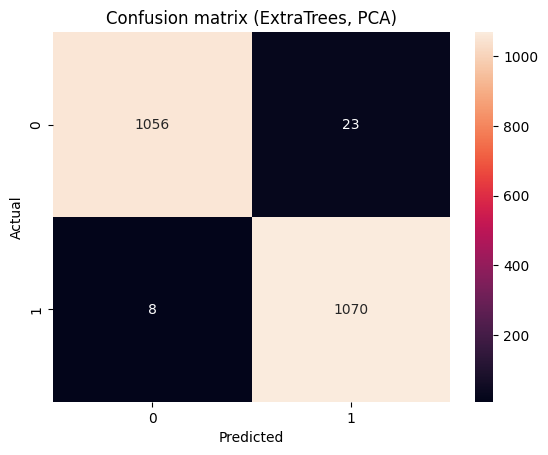

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_bal, y_pca_bal, test_size=0.3, stratify=y_pca_bal, random_state=42)
best_et.fit(X_train, y_train)
y_pred = best_et.predict(X_test)
y_proba = best_et.predict_proba(X_test)[:,1]

print("Test metrics for ExtraTrees (PCA):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix (ExtraTrees, PCA)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# 12. Save model if desired


In [22]:
import joblib
# Save the fitted scaler, PCA, and final ExtraTrees model
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(best_et, "best_extratrees_pca.pkl")

print("Saved: scaler.pkl, pca.pkl, best_extratrees_pca.pkl")


Saved: scaler.pkl, pca.pkl, best_extratrees_pca.pkl


In [26]:
# Download the model file to your local machine (Google Colab)
from google.colab import files
files.download('best_extratrees_pca.pkl')

ModuleNotFoundError: No module named 'google'

## Quick end‑to‑end summary (what we did and why)

- **Cleaned the Framingham dataset** so that all models receive numeric, NaN‑free inputs.  
- **Engineered clinically meaningful features** (pulse pressure, MAP, age×BP) to better capture cardiovascular risk.  
- **Created three feature views**: all features, an **mRMR‑selected subset**, and a **12‑component PCA representation**.  
- **Balanced the dataset** via oversampling to handle the rare CHD cases fairly.  
- **Trained and compared multiple model configurations** (simple/medium/complex) across 8 different model families on each feature view with 10-fold cross‑validation, measuring not just accuracy but also model size, training time, and prediction latency.
- **Tuned an ExtraTrees model** on the PCA features using RandomizedSearchCV for stronger performance.  
- **Evaluated the tuned model on a held‑out test set** to estimate real‑world generalization.  
- **Explained the model's behavior with SHAP and LIME** to understand both global patterns and individual predictions.  
- **Saved the final model** so it can be reused without retraining.

You can now experiment with:

- Changing which features go into mRMR or PCA.  
- Adding more model configurations (e.g., ultra-simple for edge deployment, or ultra-complex for maximum accuracy).
- Tuning other high-performing model families identified in the comparison (e.g., XGBoost, SVC).  
- Applying SHAP/LIME to alternative models for comparison.
- Adjusting the complexity levels to find the sweet spot between performance and deployment constraints.

**Key insight**: The comprehensive comparison across models, configurations, and feature sets helps you make informed tradeoffs between accuracy, interpretability, model size, and prediction speed—critical considerations for deploying ML in healthcare.